In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler
from scipy.stats.mstats import winsorize
import joblib

In [2]:
df = pd.read_parquet("../data/processed/production_clean.parquet")



In [3]:
null_report = df.isnull().sum().to_frame("Nulls")
null_report["Percentage"] = (null_report["Nulls"]/len(df)) * 100
display(null_report[null_report["Nulls"] > 0].style.background_gradient(cmap="Reds"))

,Nulls,Percentage


In [4]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["week_year"] = df["date"].dt.isocalendar().week

df["harvest_season"] = df["month"].apply(lambda x: 1 if x in [3, 4, 5] else 0)

In [5]:
df.head()

,date,cheese,milk,dulce_leche,eggs,porks,vegetables,cheese_revenue,milk_revenue,dulce_leche_revenue,eggs_revenue,porks_revenue,vegetables_revenue,season,year,month,week_year,harvest_season
0,2020-01-01,20,300,5,1,1,10,300,900,50,12,300,20,Summer,2020,1,1,0
1,2020-02-01,25,310,3,2,1,12,375,930,30,24,300,24,Summer,2020,2,5,0
2,2020-03-01,28,320,4,5,1,18,420,960,40,60,300,36,Summer,2020,3,9,1
3,2020-04-01,30,290,2,3,1,25,450,870,20,36,300,50,Fall,2020,4,14,1
4,2020-05-01,35,330,3,6,1,30,525,990,30,72,300,60,Fall,2020,5,18,1


In [6]:

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df.head(3)

,date,cheese,milk,dulce_leche,eggs,porks,vegetables,cheese_revenue,milk_revenue,dulce_leche_revenue,eggs_revenue,porks_revenue,vegetables_revenue,season,year,month,week_year,harvest_season,month_sin,month_cos
0,2020-01-01,20,300,5,1,1,10,300,900,50,12,300,20,Summer,2020,1,1,0,0.500000,8.660254e-01
1,2020-02-01,25,310,3,2,1,12,375,930,30,24,300,24,Summer,2020,2,5,0,0.866025,5.000000e-01
2,2020-03-01,28,320,4,5,1,18,420,960,40,60,300,36,Summer,2020,3,9,1,1.000000,6.123234e-17


In [7]:
scaler = RobustScaler()
df[["cheese", "milk", "dulce_leche", "vegetables", "eggs", "porks"]] = scaler.fit_transform(df[["cheese", "milk", "dulce_leche", "vegetables", "eggs", "porks"]])

display(df[["cheese", "milk", "dulce_leche", "vegetables", "eggs", "porks"]].describe().T)

,count,mean,std,min,25%,50%,75%,max
cheese,60.0,-0.117778,0.854664,-1.733333,-0.666667,0.0,0.333333,2.800000
milk,60.0,-0.007821,0.554069,-0.954481,-0.503989,0.0,0.496011,1.016424
dulce_leche,60.0,0.140541,0.742167,-0.972973,-0.432432,0.0,0.567568,2.162162
vegetables,60.0,0.205128,0.942852,-0.839161,-0.300699,0.0,0.699301,5.006993
eggs,60.0,0.034703,0.618324,-0.630137,-0.575342,0.0,0.424658,2.054795
porks,60.0,0.111111,0.674856,-0.666667,-0.500000,0.0,0.500000,2.333333


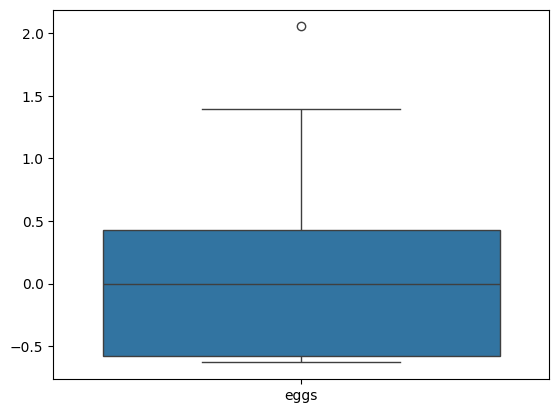

In [8]:
sns.boxplot(data=df[["eggs"]]);

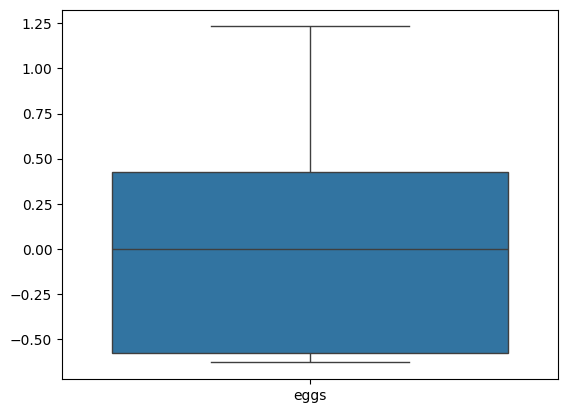

In [9]:

df['eggs'] = winsorize(df['eggs'], limits=[0.05, 0.05])

sns.boxplot(data=df[['eggs']]);

In [10]:
numeric_df = df.select_dtypes(include='number')  
corr_matrix = numeric_df.corr()["cheese_revenue"].sort_values(ascending=False)
display(corr_matrix[abs(corr_matrix) > 0.3])


cheese_revenue         1.000000
cheese                 0.927158
dulce_leche_revenue    0.662713
dulce_leche            0.599997
eggs_revenue           0.528551
eggs                   0.526346
milk                   0.485010
milk_revenue           0.473041
month                  0.469460
vegetables             0.383929
vegetables_revenue     0.383929
year                   0.363102
week_year              0.335382
porks_revenue          0.317724
porks                  0.317724
month_sin             -0.373447
Name: cheese_revenue, dtype: float64

In [11]:
df = df.sort_values('date')

df['target'] = df['cheese'].shift(-1) 

df = df.dropna(subset=['target'])

split_idx = int(len(df) * 0.8)
train, test = df.iloc[:split_idx], df.iloc[split_idx:]

In [12]:
train.to_parquet('../data/processed/train.parquet')
test.to_parquet('../data/processed/test.parquet')

In [13]:
joblib.dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

<Axes: xlabel='milk', ylabel='Count'>

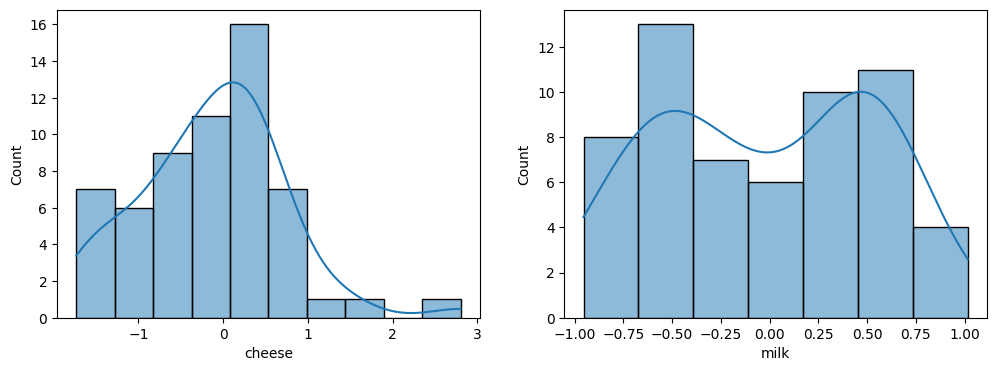

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['cheese'], ax=axes[0], kde=True)
sns.histplot(df['milk'], ax=axes[1], kde=True)

In [15]:
train

,date,cheese,milk,dulce_leche,eggs,porks,vegetables,cheese_revenue,milk_revenue,dulce_leche_revenue,...,porks_revenue,vegetables_revenue,season,year,month,week_year,harvest_season,month_sin,month_cos,target
0,2020-01-01,-1.555556,-0.503989,-0.432432,-0.630137,-0.500000,-0.699301,300,900,50,...,300,20,Summer,2020,1,1,0,5.000000e-01,8.660254e-01,-1.333333
1,2020-02-01,-1.333333,-0.485218,-0.648649,-0.575342,-0.500000,-0.643357,375,930,30,...,300,24,Summer,2020,2,5,0,8.660254e-01,5.000000e-01,-1.200000
2,2020-03-01,-1.200000,-0.466448,-0.540541,-0.410959,-0.500000,-0.475524,420,960,40,...,300,36,Summer,2020,3,9,1,1.000000e+00,6.123234e-17,-1.111111
3,2020-04-01,-1.111111,-0.522759,-0.756757,-0.520548,-0.500000,-0.279720,450,870,20,...,300,50,Fall,2020,4,14,1,8.660254e-01,-5.000000e-01,-0.888889
4,2020-05-01,-0.888889,-0.447677,-0.648649,-0.356164,-0.500000,-0.139860,525,990,30,...,300,60,Fall,2020,5,18,1,5.000000e-01,-8.660254e-01,-0.666667
5,2020-06-01,-0.666667,-0.316283,-0.324324,-0.191781,-0.333333,0.000000,600,1200,60,...,600,70,Fall,2020,6,23,0,1.224647e-16,-1.000000e+00,-0.444444
6,2020-07-01,-0.444444,-0.278742,-0.108108,-0.082192,-0.166667,0.139860,675,1260,80,...,900,80,Winter,2020,7,27,0,-5.000000e-01,-8.660254e-01,-0.222222
7,2020-08-01,-0.222222,-0.241201,0.000000,-0.027397,-0.166667,0.279720,750,1320,90,...,900,90,Winter,2020,8,31,0,-8.660254e-01,-5.000000e-01,0.000000
8,2020-09-01,0.000000,-0.203660,0.108108,0.027397,0.000000,0.419580,825,1380,100,...,1200,100,Winter,2020,9,36,0,-1.000000e+00,-1.836970e-16,0.222222
9,2020-10-01,0.222222,-0.166119,0.324324,0.082192,0.166667,0.559441,900,1440,120,...,1500,110,Spring,2020,10,40,0,-8.660254e-01,5.000000e-01,0.444444
